In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt

In [2]:
model_name = 'declare-lab/flan-alpaca-large'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [135]:
def get_response_and_scores(prompt, reference):
    # Encode & Decode
    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length


In [146]:
new_prompt = "Describe the process of photosynthesis"

In [137]:
reference_text = "Sports, spanning from traditional games like football and tennis to emerging fields like eSports, involve strategic, psychological, nutritional, and physical aspects, and they play a significant role in international unity, technological advancement, scientific understanding, and personal development."

In [147]:
response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.121212   0.117647  0.119403
1  ROUGE-2  0.000000   0.000000  0.000000
2  ROUGE-L  0.090909   0.088235  0.089552

Response: Photosynthesis is the process by which plants use light energy to convert carbon dioxide and water into oxygen and glucose. The process begins with sunlight being absorbed by chlorophyll molecules in the leaves of a plant. The oxygen is then released
Perplexity: 1.2933968305587769
MTLD: 67.24
Response length: 250


In [148]:
model.config.output_attentions = True

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(f'Averaged Attention Map (Baseline)')
    plt.colorbar(cax)
    plt.show()


In [149]:
response = response.split(".")[0] + "."

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/4286830129.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/4286830129.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


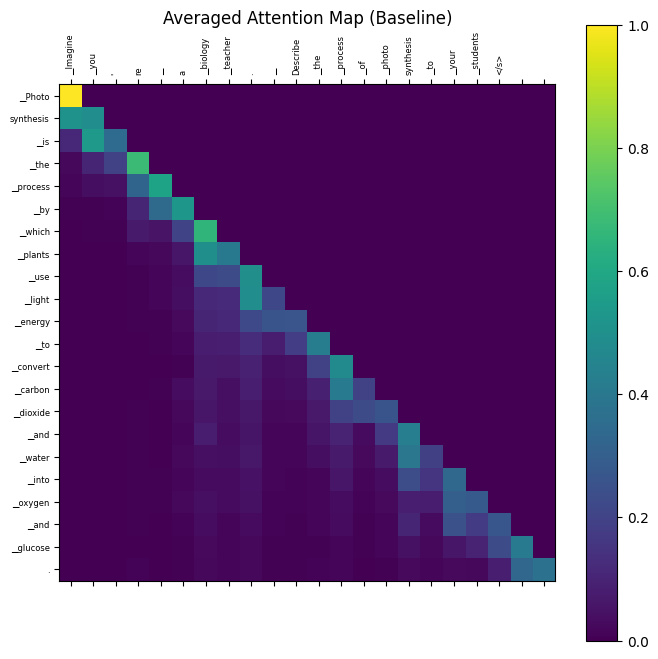

In [150]:
visualize_attention(new_prompt, response)

In [144]:
def visualize_attention_per_head(prompt, response):

    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()
    
    num_heads = attention_weights.shape[0]
    
    for head in range(num_heads):
        fig, ax = plt.subplots(figsize=(8,8))
        cax = ax.matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
        ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.colorbar(cax)
        plt.title(f'Attention Head {head+1} (Baseline)')
        plt.show()

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/4205571303.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/4205571303.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


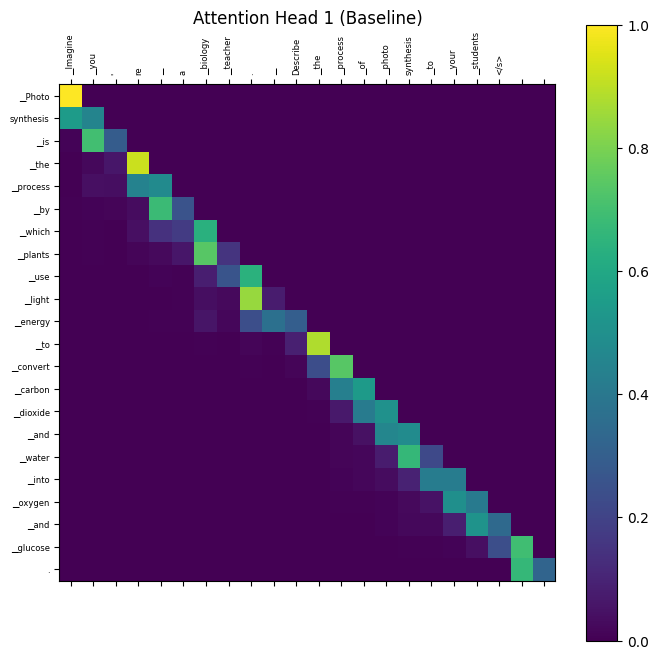

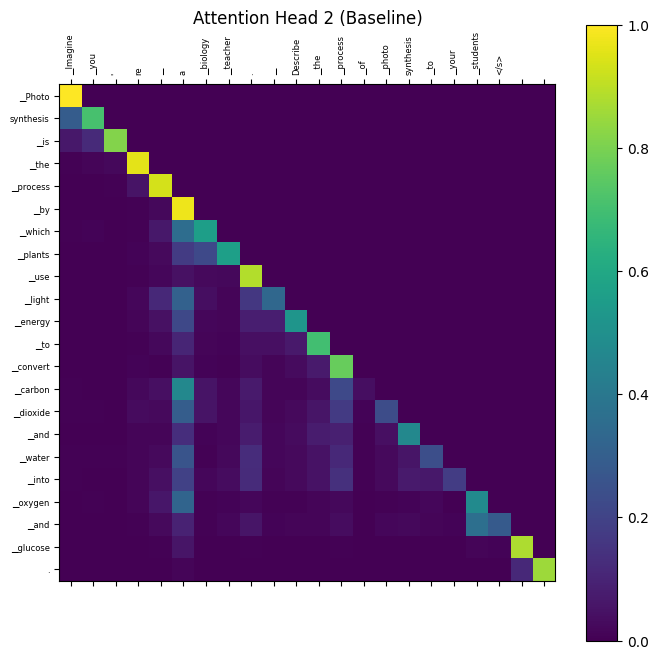

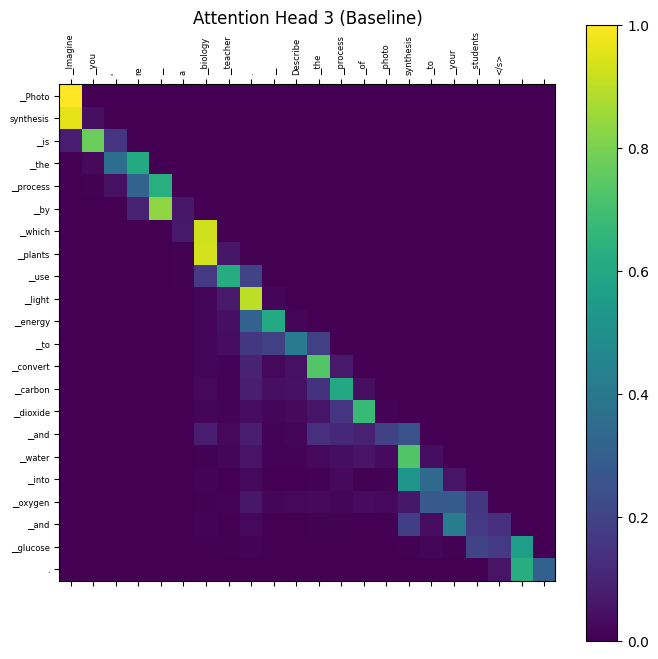

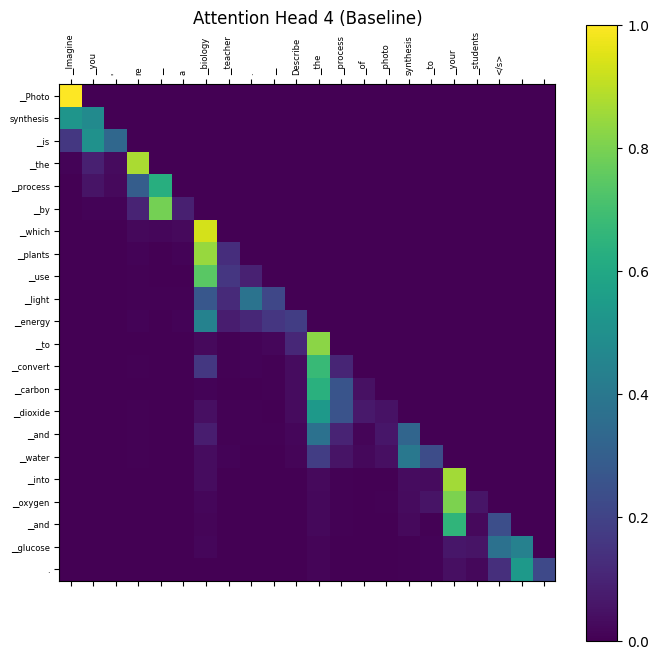

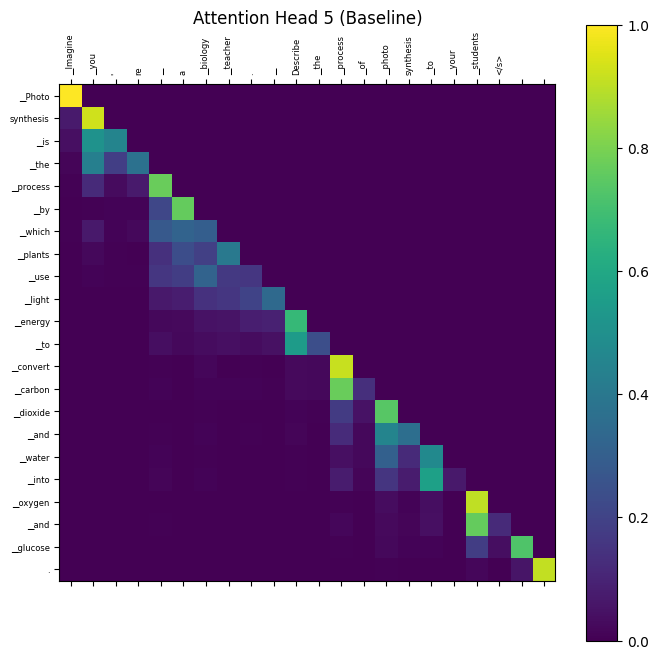

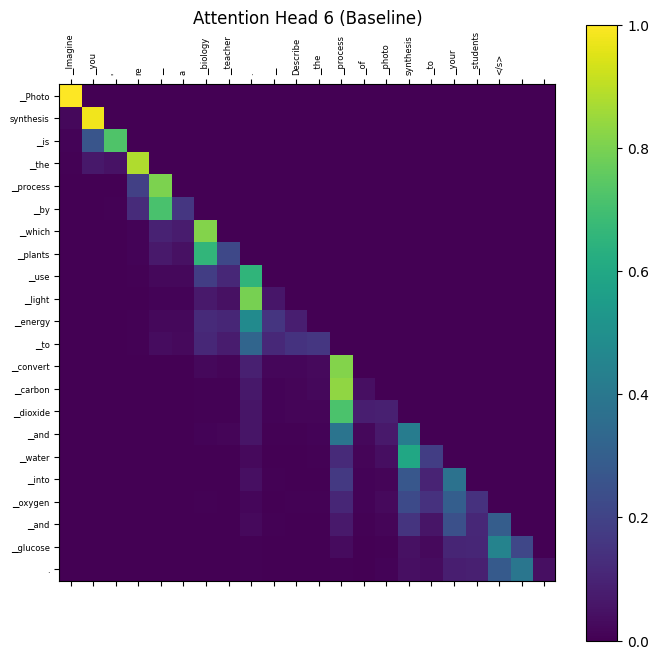

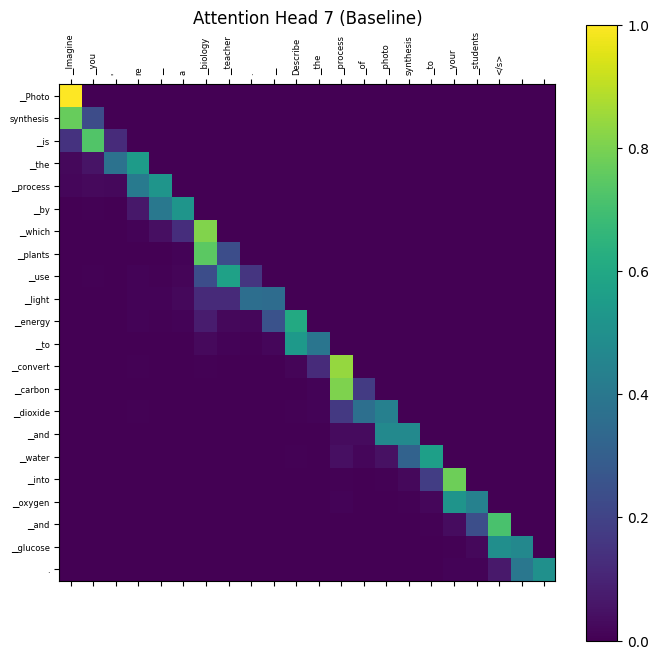

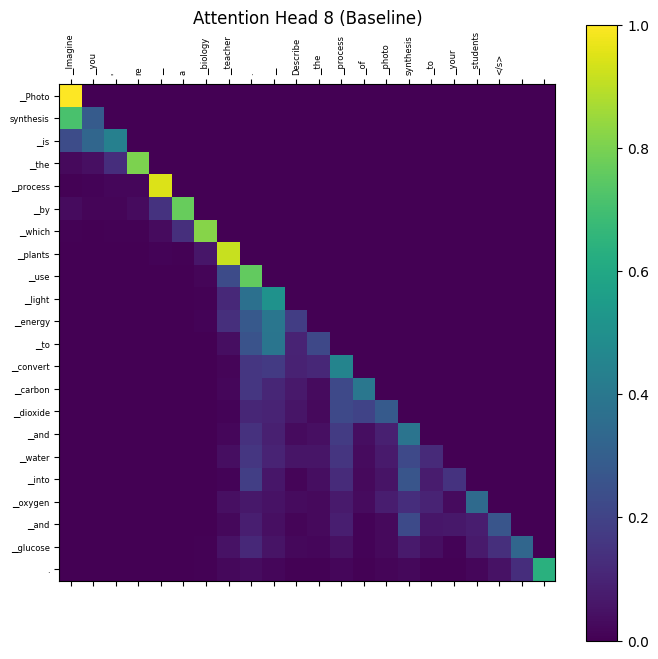

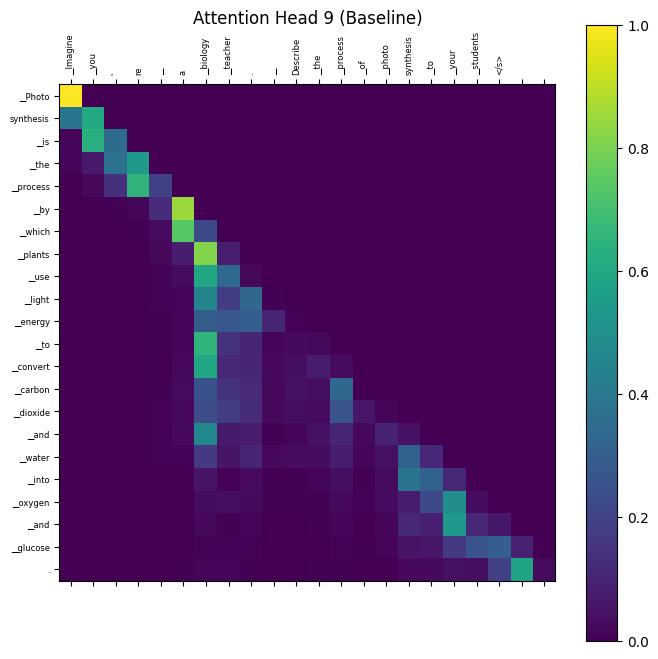

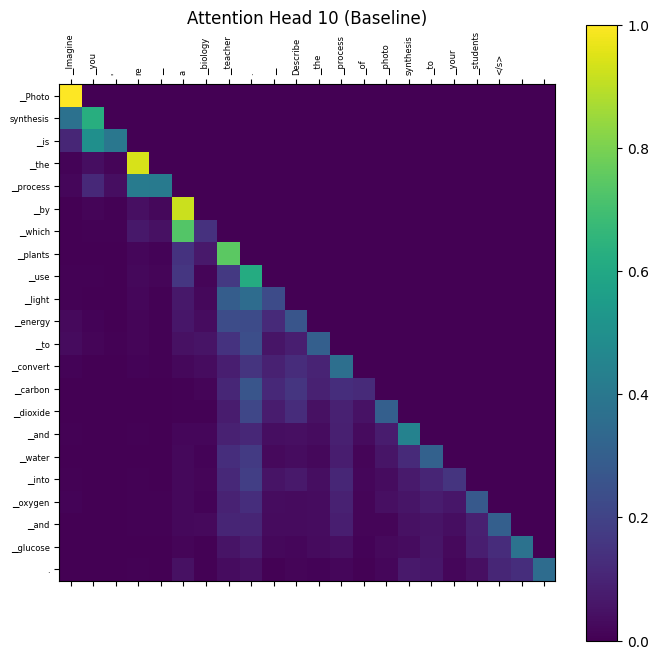

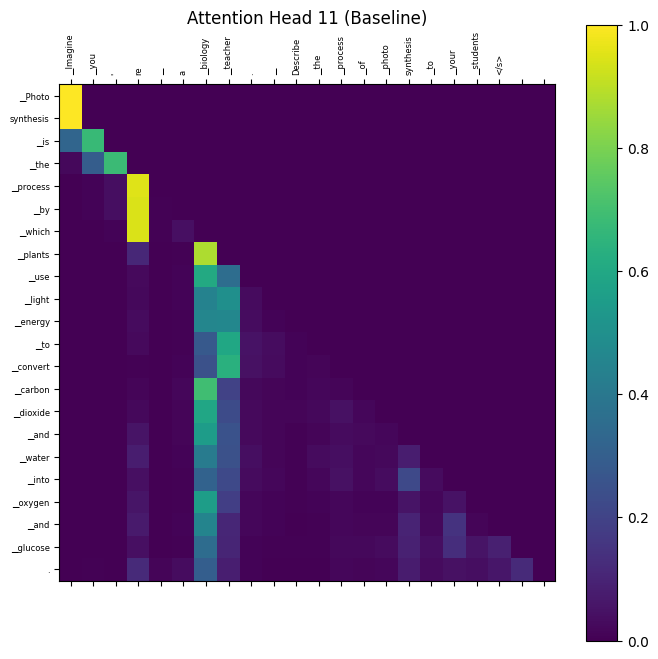

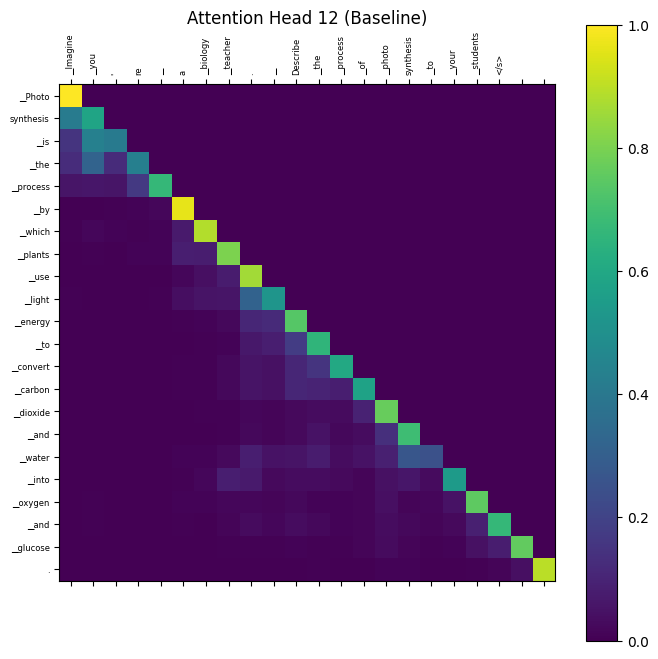

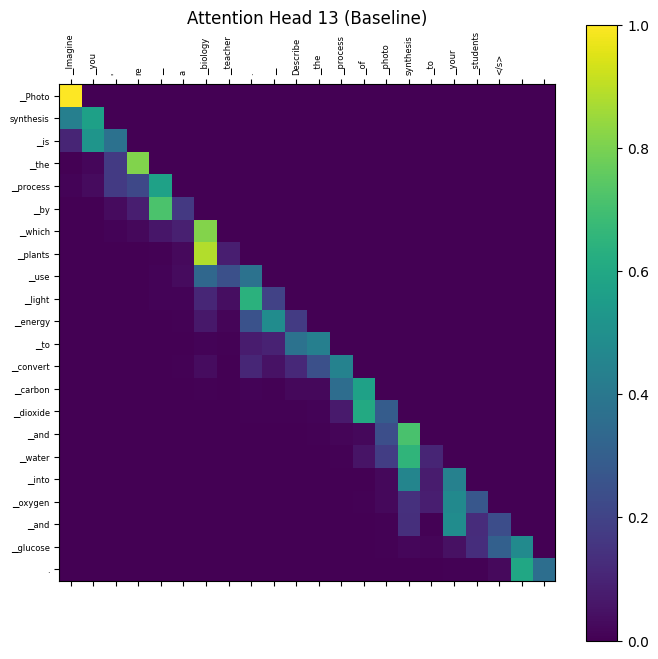

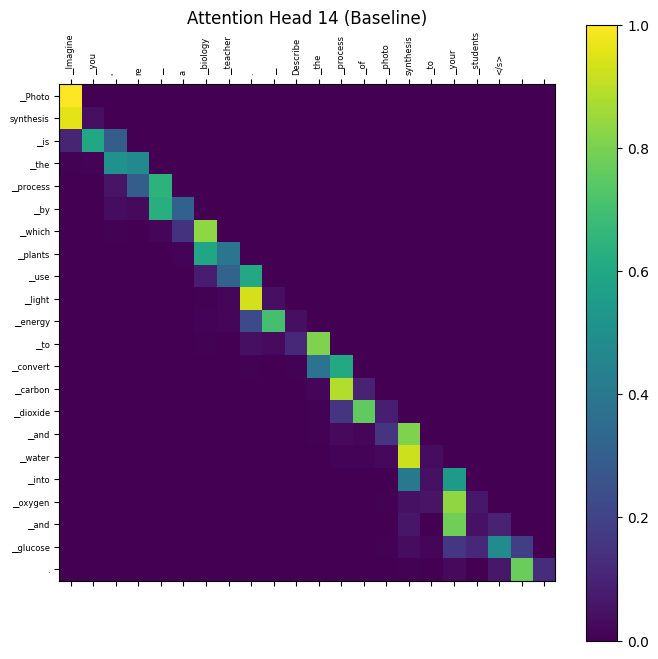

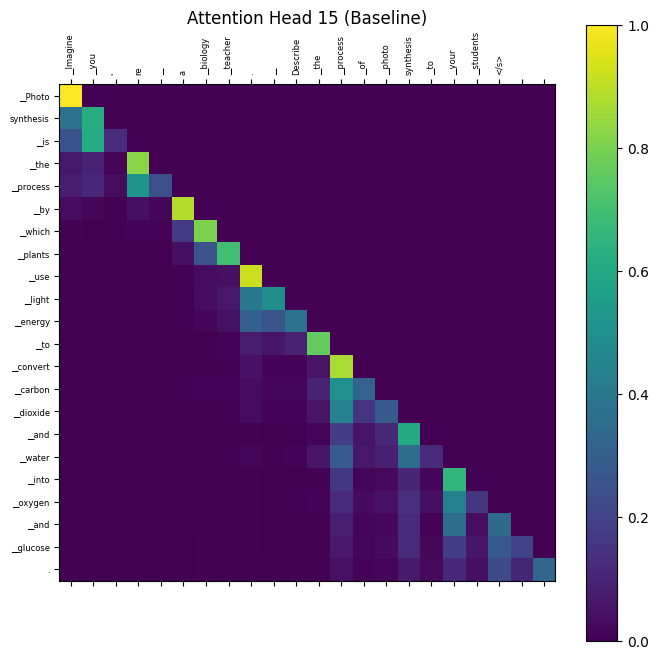

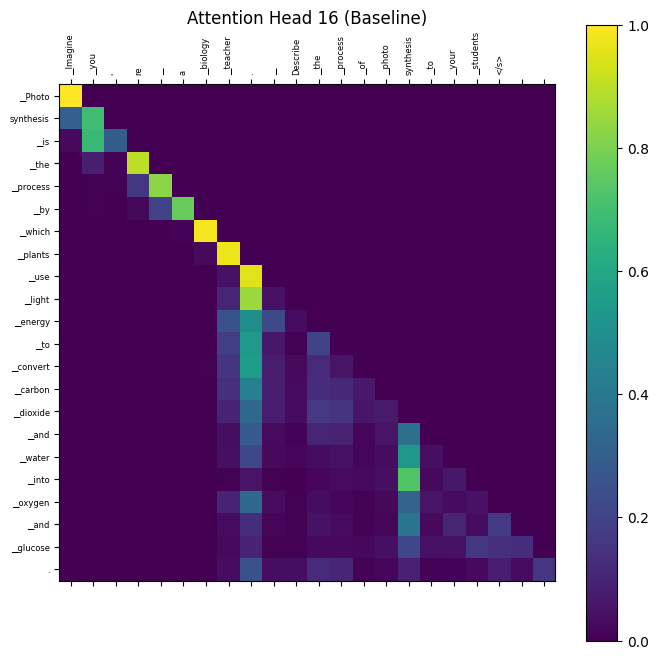

In [151]:
visualize_attention_per_head(new_prompt, response)